In [ ]:
# Calculate the cloud difference between 
# (1) clr/clr and (2) cloudy/cloudy group
# and also compare the "BC cloud" and "noBC cloud"
# check the model cloud proxy vs obs cloud proxy with/without BC and comparison between different experiments
# it runs slow, run with cautious!!
# initial built: 2024/09/09

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import netCDF4 as nc


In [230]:
#exps=['ctrl', 'ctrl_noinf','ctrl_amsua_ch5', 'only_clr_clr', 'clr_clr_and_cld_cld_0.05', 'clr_clr_and_cld_cld_0.05_varbcpred_sym_cld', \
#      'clr_clr_and_cld_cld_0.05_varbcpred_obs_cld', 'clr_clr_and_cld_cld_0.05_varbcpred_model_cld']

#exps=['ctrl', 'ctrl_noinf']
exps=['only_clr_clr', 'clr_clr_and_cld_cld_0.05', \
      'clr_clr_and_cld_cld_0.05_varbcpred_sym_cld', \
      'clr_clr_and_cld_cld_0.05_varbcpred_obs_cld', \
      'clr_clr_and_cld_cld_0.05_varbcpred_model_cld',  ]
instr='amsua'
sats=['n15','n18','n19','metop-c']
gesanl='ges'

init_time  = datetime(2022, 6, 15, 0, 0, 0)  # Year, month, day, hour, minute, second
final_time = datetime(2022, 7, 20, 0, 0, 0)  # Year, month, day, hour, minute, second
dt         = 12 # in hours

In [231]:
def ret_amsua(tb_ch1, tb_ch2, zasat):
    # tb_ch1: brightness temperature of channel 1
    # tb_ch2: brightness temperature of channel 2
    # zasat: zenith angle
    
    coszat = np.cos(np.radians(zasat))
    d0 = 8.240 - (2.622 - 1.846*coszat)*coszat
    d1 = 0.754
    d2 = -2.265
    
    ret_cld=coszat*(d0 + d1*np.log(285-tb_ch1) + d2*np.log(285-tb_ch2))
    
    return max(0,ret_cld)

In [232]:
#chn = 3 # channel to be examined # Note: the cloud definitions are the same for all channels

if instr == 'amsua':
    nchan = 15

lat_use={}; lon_use={}; ch_use={}; 
tb_obs_use={}; tb_model_use={}; tbnbc_model_use={};
obs_cld_use={}; model_cld_use={}; model_cldnbc_use={}; model_cld_test={}; cld_diff_bc_use={}; cld_diff_nbc_use={};


for exp in exps:
    key = exp
    lat_use.setdefault(key, [])
    lon_use.setdefault(key, [])
    #ch_use.setdefault(key, [])
    #tb_obs_use.setdefault(key, [])
    #tb_model_use.setdefault(key, [])
    #tbnbc_model_use.setdefault(key, [])
    obs_cld_use.setdefault(key, [])
    model_cld_use.setdefault(key, [])
    model_cldnbc_use.setdefault(key, [])
    #cld_diff_bc_use.setdefault(key, [])
    #cld_diff_nbc_use.setdefault(key, [])
    #model_cld_test.setdefault(key, [])
    
    print(f'processing {exp} ...')
    
    current_time = init_time
    while current_time <= final_time:
        format_time  = current_time.strftime("%Y%m%d%H")
        if (current_time.hour == 0) & (np.mod(current_time.day,5)== 0):
            print(f'time = {format_time}')
            
        for sat in sats:
            root = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/radstats/{instr}/{exp}/'
            fn = f'diag_{instr}_{sat}_{gesanl}.{format_time}.nc4'
            rr = nc.Dataset(f"{root}/{fn}")

            ch         = rr.variables['Channel_Index'][:]
            lat        = rr.variables['Latitude'][:]
            lon        = rr.variables['Longitude'][:]
            qc         = rr.variables['QC_Flag'][:]
            zasat      = rr.variables['Sat_Zenith_Angle'][:]
            clw_obs    = rr.variables['clw_obs'][:]
            clw_model  = rr.variables['clw_guess_retrieval'][:]
            inv_err    = rr.variables['Inverse_Observation_Error'][:]
            o          = rr.variables['Observation'][:]
            omf        = rr.variables['Obs_Minus_Forecast_adjusted'][:]
            omfnbc     = rr.variables['Obs_Minus_Forecast_unadjusted'][:]
            fwater     = rr.variables['Water_Fraction'][:]

            ntotal = len(ch)
            npt    = int(ntotal/nchan)
            for d in range(npt):
                idx = d*nchan
                sea_screen  = (fwater[idx]>= 0.99)
                #use         = (sea_screen)&(qc[idx]==0)&(qc[idx+1]==0)&(qc[idx+2]==0)&(qc[idx+3]==0)&(qc[idx+4]==0)&(qc[idx+14]==0)
                use         = (sea_screen)&(inv_err[idx]>0)&(inv_err[idx+1]>0)&(inv_err[idx+2]>0)&(inv_err[idx+3]>0)& \
                              (inv_err[idx+4]>0)&(inv_err[idx+14]>0)

                if use:
                    lat_use[exp].append(lat[idx])
                    lon_use[exp].append(lon[idx])

                    obs_cld_use[exp].append(clw_obs[idx])
                    model_cld_use[exp].append(clw_model[idx])
                    
                    #cld_diff_bc_use[exp].append(clw_obs[idx]-clw_model[idx])

                    #idx_ch = idx+chn-1
                    #ch_use[exp].append(ch[idx_ch])
                    #tb_obs_use[exp].append(o[idx_ch])

                    #tb_model_use[exp].append(o[idx_ch]-omf[idx_ch])
                    #tbnbc_model_use[exp].append(o[idx_ch]-omfnbc[idx_ch])

                    #obs_cld_use[exp].append(clw_obs[idx_ch])
                    #model_cld_use[exp].append(clw_model[idx_ch])

                    # test the consistency of the retrieval formula:
                    #zenith_tmp = zasat[idx_ch]
                    zenith_tmp = zasat[idx]

                    tb1_tmp = o[idx+1-1]-omf[idx+1-1]
                    tb2_tmp = o[idx+2-1]-omf[idx+2-1]

                    tb1nbc_tmp = o[idx+1-1]-omfnbc[idx+1-1]
                    tb2nbc_tmp = o[idx+2-1]-omfnbc[idx+2-1]

                    #model_cld_test[exp].append( ret_amsua(tb1_tmp, tb2_tmp, zenith_tmp) )
                    model_cldnbc_use[exp].append( ret_amsua(tb1nbc_tmp, tb2nbc_tmp, zenith_tmp) )
                    
                    #cld_diff_nbc_use[exp].append(clw_obs[idx]-ret_amsua(tb1nbc_tmp, tb2nbc_tmp, zenith_tmp))
                
        # progress to the next time step
        current_time = current_time + timedelta(hours=dt)

processing only_clr_clr ...
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_clr_and_cld_cld_0.05 ...
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_clr_and_cld_cld_0.05_varbcpred_sym_cld ...
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_clr_and_cld_cld_0.05_varbcpred_obs_cld ...
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_clr_and_cld_cld_0.05_varbcpred_model_cld ...
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000


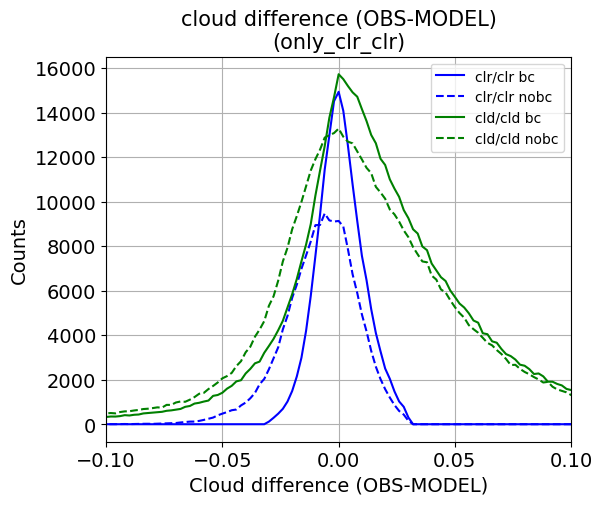

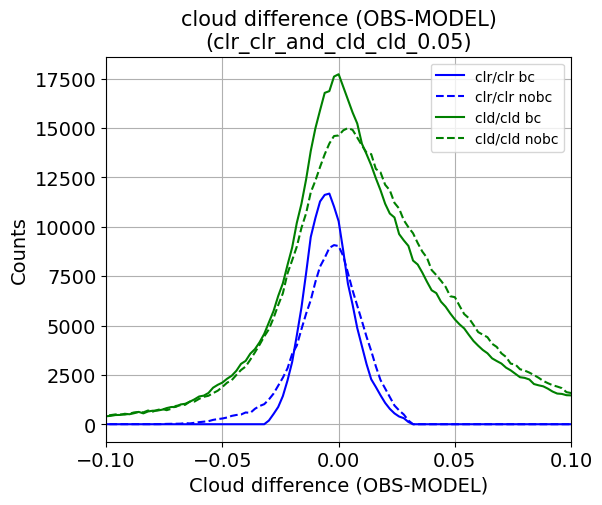

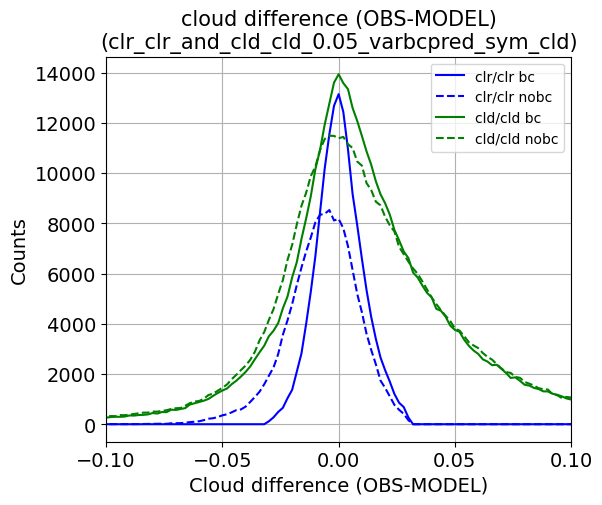

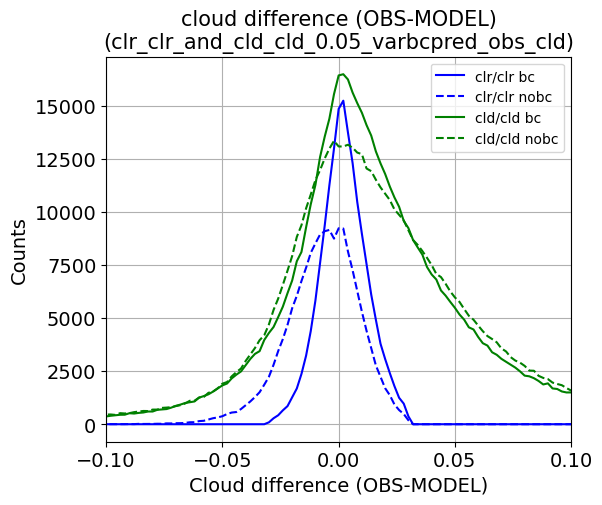

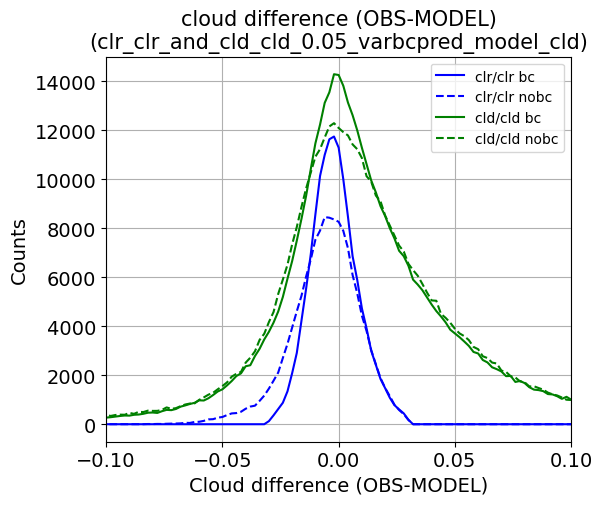

In [234]:
# Plot the clr/clr and cld/cld cloud difference distribution
# This should be independent of which channel is chosen to plot

dx = 0.002
bin_max = 1.2

bins = np.arange(-0.5+dx/2, 0.5+dx/2, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    cldbc  = np.array(model_cld_use[exp])
    cldnbc = np.array(model_cldnbc_use[exp])
    cldobs = np.array(obs_cld_use[exp])
    #clddiffbc  = np.array(cld_diff_bc_use[exp])
    #clddiffnbc = np.array(cld_diff_nbc_use[exp])
    
    # not sure??
    cri_val = 1e-15
    additional_cri = (abs(cldobs - cldbc) > cri_val) & (abs(cldobs - cldnbc) > cri_val)  
    useclr = np.where( (cldbc<=0.03) & (cldobs<=0.03) & additional_cri )
    usecld = np.where( (cldbc> 0.03) & (cldobs> 0.03) & additional_cri )
    
    ct_clr_omfbc, _  = np.histogram(cldobs[useclr] -  cldbc[useclr], bins=bins)
    ct_clr_omfnbc, _ = np.histogram(cldobs[useclr] - cldnbc[useclr], bins=bins)
    ct_cld_omfbc, _  = np.histogram(cldobs[usecld] -  cldbc[usecld], bins=bins)
    ct_cld_omfnbc, _ = np.histogram(cldobs[usecld] - cldnbc[usecld], bins=bins) 
    
    '''
    ct_clr_omfbc, _  = np.histogram(clddiffbc[useclr],  bins=bins)
    ct_clr_omfnbc, _ = np.histogram(clddiffnbc[useclr], bins=bins)
    ct_cld_omfbc, _  = np.histogram(clddiffbc[usecld],  bins=bins)
    ct_cld_omfnbc, _ = np.histogram(clddiffnbc[usecld], bins=bins) 
    '''
    
    fig, ax = plt.subplots(figsize=(6,5))

    ax.plot(bin_center, ct_clr_omfbc,  linestyle='-',  color='blue',  label='clr/clr bc')
    ax.plot(bin_center, ct_clr_omfnbc, linestyle='--', color='blue',  label='clr/clr nobc')
    ax.plot(bin_center, ct_cld_omfbc,  linestyle='-',  color='green', label='cld/cld bc')
    ax.plot(bin_center, ct_cld_omfnbc, linestyle='--', color='green', label='cld/cld nobc')
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xlim(-0.1,0.1)
    #plt.xlim(-1e-3,1e-3)
    ax.set_xlabel('Cloud difference (OBS-MODEL)',fontsize=14)
    ax.set_ylabel('Counts',fontsize=14)
    
    ax.grid(True)
    ax.set_title(f'cloud difference (OBS-MODEL)\n({exp})', fontsize=15)
    ax.legend()
    plt.savefig(f'clr_clr_cld_cld_clddiff_{exp}.png', dpi=200, bbox_inches='tight')    

In [203]:
useclr

(array([    66,     70,     74, ..., 146240, 146241, 146249]),)

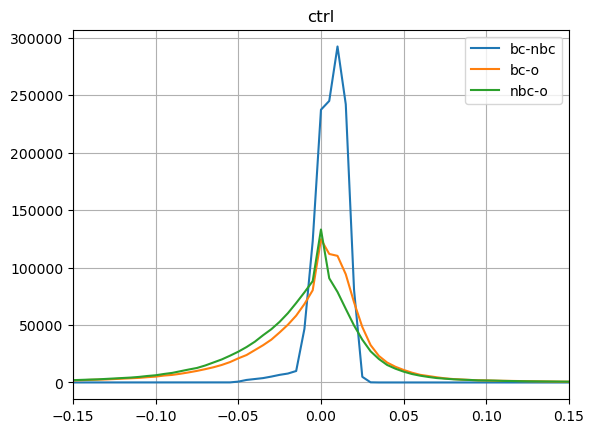

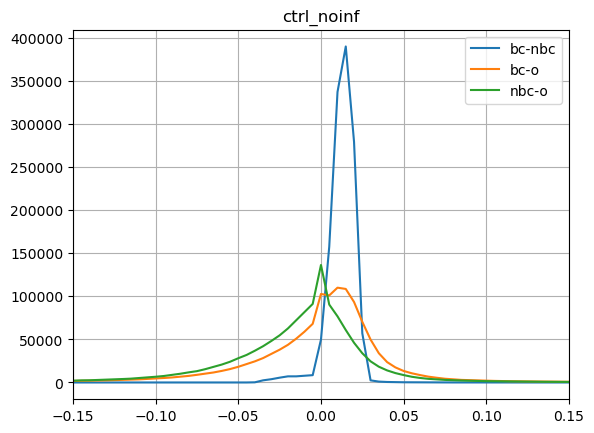

In [154]:
# histogram of all data

dx = 0.005
bin_max = 1.2

bins = np.arange(-0.5+dx/2, 0.5+dx/2, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    cld    = np.array(model_cld_use[exp])
    cldnbc = np.array(model_cldnbc_use[exp])
    cldobs = np.array(obs_cld_use[exp])
    
    counts_diff, _   = np.histogram(cld-cldnbc,    bins=bins)
    counts_fbcmo, _  = np.histogram(cld-cldobs,    bins=bins)
    counts_fnbcmo, _ = np.histogram(cldnbc-cldobs, bins=bins)
    
    plt.plot(bin_center, counts_diff,   label='bc-nbc')
    plt.plot(bin_center, counts_fbcmo,  label='bc-o')
    plt.plot(bin_center, counts_fnbcmo, label='nbc-o')
    #plt.xlim(0,0.3)
    plt.xlim(-0.15,0.15)
    plt.grid(True)
    plt.title(f'{exp}')
    plt.legend()
    plt.show()

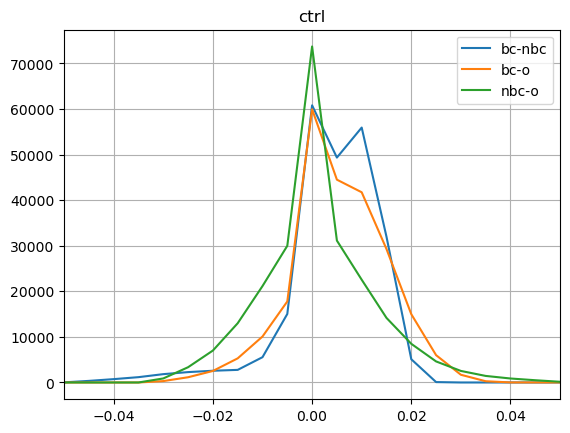

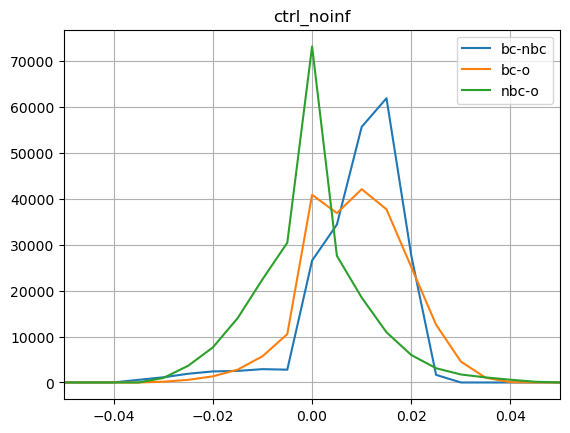

In [155]:
# histogram of only clr/clr

dx = 0.005
bin_max = 1.2

bins = np.arange(-0.5+dx/2, 0.5+dx/2, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    cld    = np.array(model_cld_use[exp])
    cldnbc = np.array(model_cldnbc_use[exp])
    cldobs = np.array(obs_cld_use[exp])

    use = np.where( (0.5*(cld+cldnbc)<=0.03) & (cldobs<=0.03) )
    
    counts_diff, _   = np.histogram(cld[use]-cldnbc[use],    bins=bins)
    counts_fbcmo, _  = np.histogram(cld[use]-cldobs[use],    bins=bins)
    counts_fnbcmo, _ = np.histogram(cldnbc[use]-cldobs[use], bins=bins)
    
    plt.plot(bin_center, counts_diff,   label='bc-nbc')
    plt.plot(bin_center, counts_fbcmo,  label='bc-o')
    plt.plot(bin_center, counts_fnbcmo, label='nbc-o')
    #plt.xlim(0,0.3)
    plt.xlim(-0.05,0.05)
    plt.grid(True)
    plt.title(f'{exp}')
    plt.legend()
    plt.show()

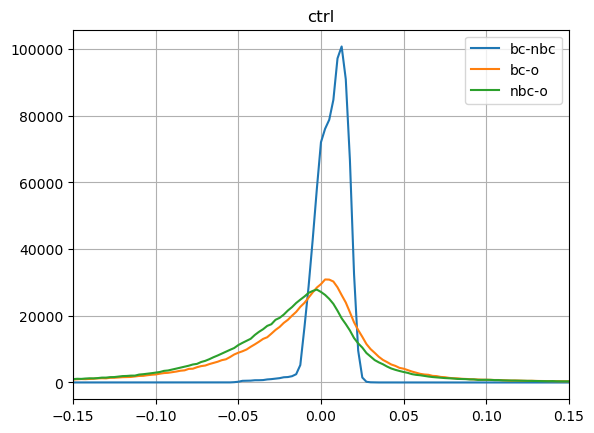

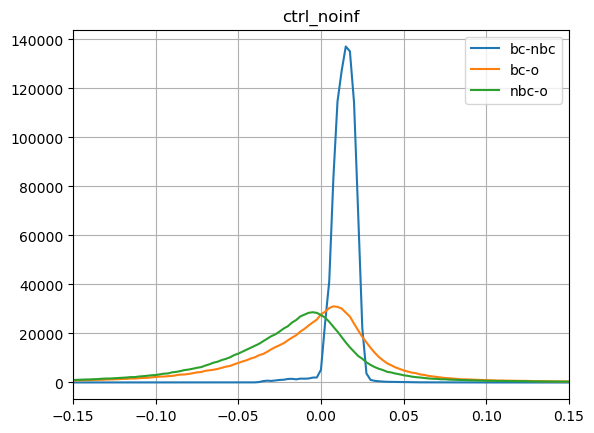

In [157]:
# histogram of only cld/cld

dx = 0.0025
bin_max = 1.2

bins = np.arange(-0.5+dx/2, 0.5+dx/2, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    cld    = np.array(model_cld_use[exp])
    cldnbc = np.array(model_cldnbc_use[exp])
    cldobs = np.array(obs_cld_use[exp])

    use = np.where( (0.5*(cld+cldnbc)>0.03) & (cldobs>0.03) )
    
    counts_diff, _   = np.histogram(cld[use]-cldnbc[use],    bins=bins)
    counts_fbcmo, _  = np.histogram(cld[use]-cldobs[use],    bins=bins)
    counts_fnbcmo, _ = np.histogram(cldnbc[use]-cldobs[use], bins=bins)
    
    plt.plot(bin_center, counts_diff,   label='bc-nbc')
    plt.plot(bin_center, counts_fbcmo,  label='bc-o')
    plt.plot(bin_center, counts_fnbcmo, label='nbc-o')
    #plt.xlim(0,0.3)
    plt.xlim(-0.15,0.15)
    plt.grid(True)
    plt.title(f'{exp}')
    plt.legend()
    plt.show()

In [ ]:
# sanity check

testval = np.array(model_cld_test['ctrl'])
refval  = np.array(model_cld_use['ctrl'])

plt.hist(testval-refval)
print(max(testval-refval))
print(min(testval-refval))
print(np.mean(np.abs(testval-refval)))

In [ ]:
qc[0:5]

In [ ]:
plt.plot(zasat[:150])

In [ ]:
# TB omf difference (use obs_space_clr_clr_cld_cld_omf_analysis file):

dx = 0.5
bin_max = 10

bins = np.arange(-bin_max, bin_max+dx, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

counts_omf, _    = np.histogram(omf,  bins=bins)
counts_omfnbc, _ = np.histogram(omfnbc,bins=bins)
counts_bcinc, _  = np.histogram(bcinc, bins=bins)
plt.plot(bin_center, counts_omf, label='o-bc')
plt.plot(bin_center, counts_omfnbc, label='o-nbc')
plt.plot(bin_center, counts_bcinc, label='bc-nbc')

plt.xlim(-bin_max,bin_max)
plt.legend()